# Data preprocessing
Stroke prediction dataset from Kaggle. Click <a href="https://www.kaggle.com/fedesoriano/stroke-prediction-dataset">here</a> to see dataset description.

**1. Reading dataset, removing missing values, splitting data to input and output**

In [ ]:
import pandas as pd
    
# Reading data
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

# removing rows with missing values
data_clean = data.dropna(axis=0)

# splitting into input and output
data_input = data_clean.drop(columns=['id', 'stroke'])
data_output = data_clean['stroke']

# print number of samples of each class
print(data_output.value_counts())

0    4700
1     209
Name: stroke, dtype: int64


**2. Undersampling: Reducing class 0 to become twice as class 1**

Use the following command to install imblearn (if not installed)

`!pip install imblearn`

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# undersampling
undersampler = RandomUnderSampler(
    sampling_strategy=0.5, random_state=0
)
x, y = undersampler.fit_resample(
    data_input, data_output
)

# print number of samples of each class
print(y.value_counts())

0    418
1    209
Name: stroke, dtype: int64


**3. Oversampling: Increasing class 1 to become equal to class 0**

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# oversampling
oversampler = RandomOverSampler(
    sampling_strategy=1.0, random_state=0
)
data_input_balanced, data_output_balanced = oversampler.fit_resample(
    x, y
)

# print number of samples of each class
print(data_output_balanced.value_counts())

0    418
1    418
Name: stroke, dtype: int64


**4. Encoding categorical features, splitting data to train-validation-test, feature scaling**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# numeric encoding
data_input_encoded = data_input_balanced.replace({
    'gender': {'Male': 0, 'Female': 1},
    'ever_married': {'Yes': 1, 'No': 0},
    'Residence_type': {'Rural': 0, 'Urban': 1}
})

# one-hot encoding
data_input_encoded_final = pd.get_dummies(data_input_encoded)

# split into (train-validation-test)
X, X_test, y, y_test = train_test_split(
    data_input_encoded_final, data_output_balanced, test_size=0.20, random_state=0
)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=0
)
print('train =', X_train.shape[0])
print('val =', X_val.shape[0])
print('test =', X_test.shape[0])

# feature scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

train = 501
val = 167
test = 168


# Artificial Neural Network

<img src="neural-network.png" alt="Neural Network Architecture" width="700px">

- We use ReLU activation function for all hidden layers.
- We use Sigmoid activation function for output layer.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

n_features = X_train_scaled.shape[1]

model = Sequential()
model.add(Dense(128, activation='relu', input_dim=n_features))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training (and validating) our neural network

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'saved-model/best-model', save_best_only=True, save_weights_only=True,
    monitor='val_loss', mode='min', verbose=1
)

history = model.fit(
    X_train_scaled, y_train, 
    validation_data=(X_val_scaled, y_val), 
    batch_size=64,
    epochs=50, 
    verbose=2,
    callbacks=[checkpoint]
)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.66051, saving model to saved-model\best-model
8/8 - 1s - loss: 0.6840 - accuracy: 0.5230 - val_loss: 0.6605 - val_accuracy: 0.5629
Epoch 2/50

Epoch 00002: val_loss improved from 0.66051 to 0.63074, saving model to saved-model\best-model
8/8 - 0s - loss: 0.6534 - accuracy: 0.6487 - val_loss: 0.6307 - val_accuracy: 0.6826
Epoch 3/50

Epoch 00003: val_loss improved from 0.63074 to 0.61097, saving model to saved-model\best-model
8/8 - 0s - loss: 0.6312 - accuracy: 0.7186 - val_loss: 0.6110 - val_accuracy: 0.7126
Epoch 4/50

Epoch 00004: val_loss improved from 0.61097 to 0.59608, saving model to saved-model\best-model
8/8 - 0s - loss: 0.6116 - accuracy: 0.7485 - val_loss: 0.5961 - val_accuracy: 0.7305
Epoch 5/50

Epoch 00005: val_loss improved from 0.59608 to 0.58488, saving model to saved-model\best-model
8/8 - 0s - loss: 0.5984 - accuracy: 0.7585 - val_loss: 0.5849 - val_accuracy: 0.7425
Epoch 6/50

Epoch 00006: val_loss improved f

# History

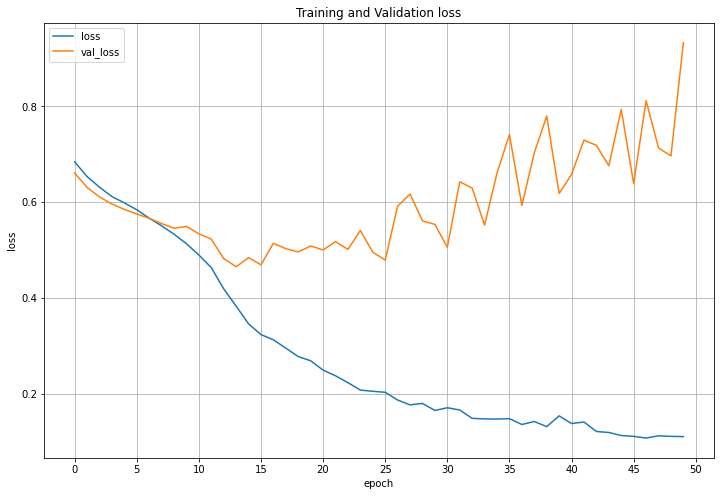

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

hist_df = pd.DataFrame(history.history)
hist_df.plot(y=['loss', 'val_loss'], figsize=(12, 8))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and Validation loss')
plt.grid(axis='both')
plt.xticks(np.arange(0, 51, 5))
plt.show()

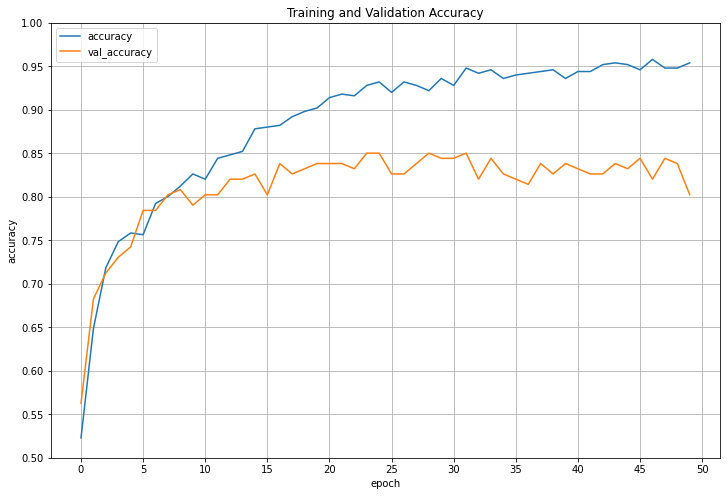

In [ ]:
hist_df = pd.DataFrame(history.history)
hist_df.plot(y=['accuracy', 'val_accuracy'], figsize=(12, 8))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training and Validation Accuracy')
plt.grid(axis='both')
plt.xticks(np.arange(0, 51, 5))
plt.yticks(np.arange(0.5, 1.01, 0.05))
plt.show()

# Testing

In [ ]:
model.load_weights('saved-model/best-model')
model.evaluate(X_test_scaled, y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.4104 - accuracy: 0.8393


[0.4103691875934601, 0.8392857313156128]